Loading atlas: ../prep_data/test/Labels/1000966359_20180113.nii.gz
Found 9 samples in 'train' set.
✅ Dataset loaded. Size: 9
✅ Heatmap: shape=(256, 256, 256), min=-1.000, max=1.000
✅ Image: shape=(256, 256, 256), min=0.000, max=1.000
✅ Cond Image: shape=(256, 256, 256), min=0.000, max=1.000
✅ Label unique values: [ 0  2  3  4  6  7  8  9 10 11 13 14 15 17 18 19 20 21 22 23 24 25 26 27
 28 30 31 32]


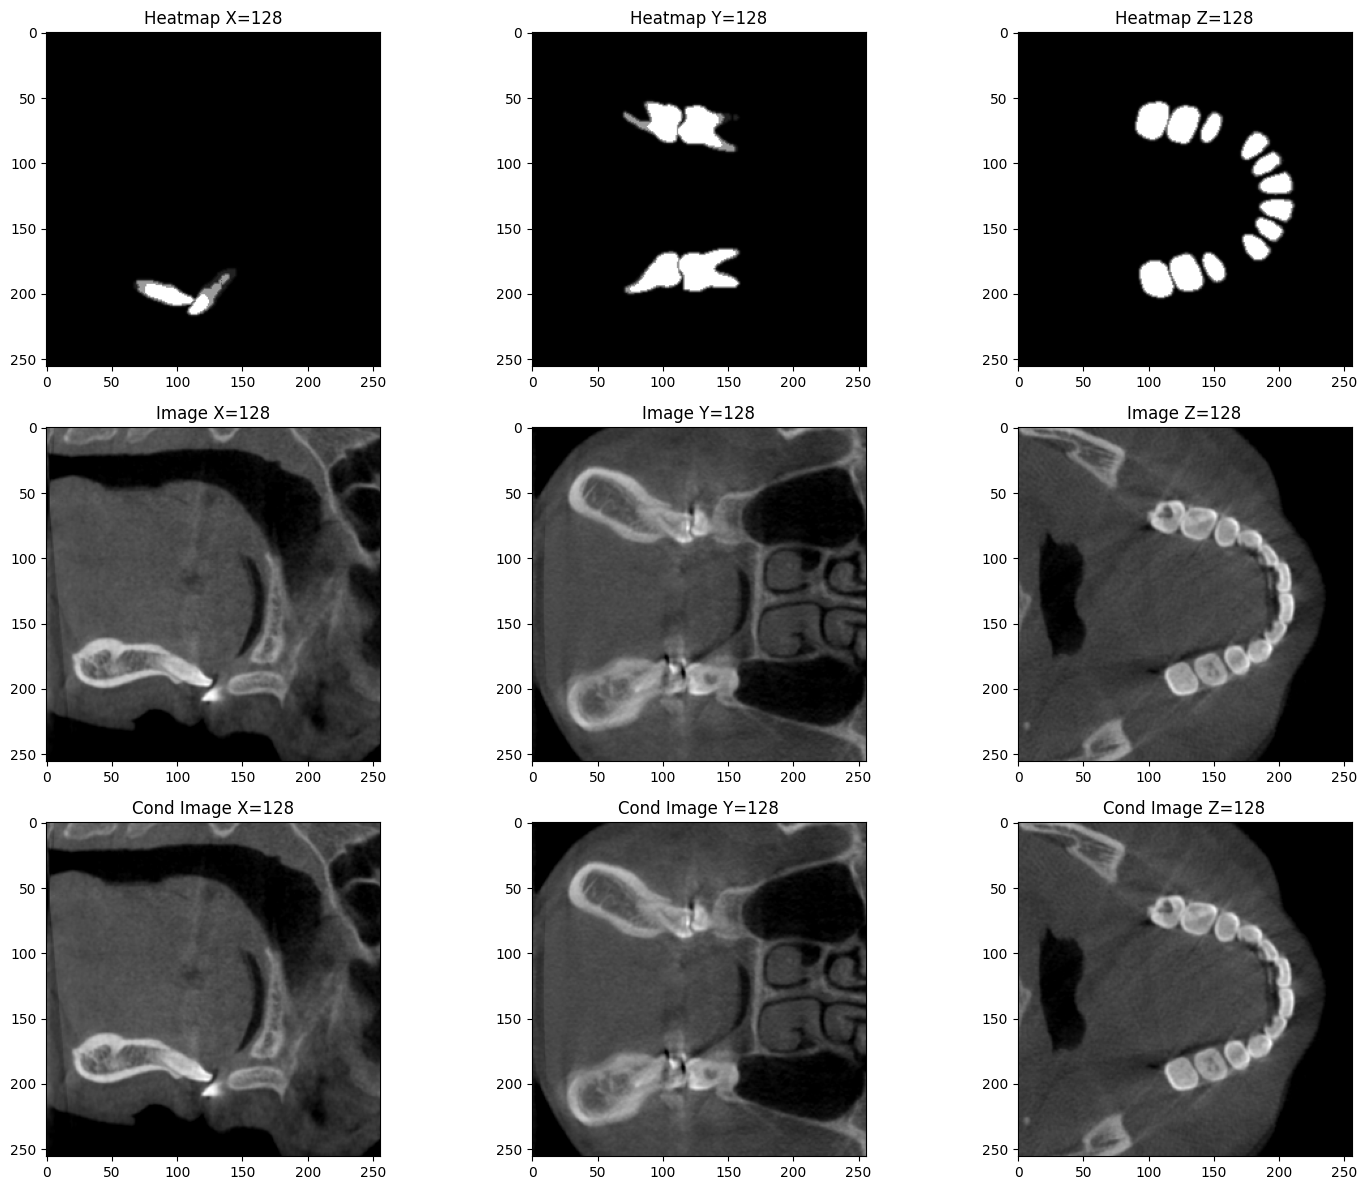

✅ Saved heatmap to heatmap_test_sample.nii.gz


In [ ]:
import matplotlib.pyplot as plt
from guided_diffusion.toothloader import ToothVolumes
from DWT_IDWT.DWT_IDWT_layer import IDWT_3D, DWT_3D
from pathlib import Path
import numpy as np
import nibabel as nib

# 📁 Paths
data_dir = "../prep_data/test"
meta_path = "../prep_data/MetaData.xlsx"
atlas_path = "../prep_data/test/Labels/1000966359_20180113.nii.gz"

# ✅ Check atlas file exists
if not Path(atlas_path).exists():
    raise FileNotFoundError(f"Atlas file not found: {atlas_path}")

# ✅ Initialize dataset
dataset = ToothVolumes(
    directory=data_dir,
    metadata_path=meta_path,
    mode='train',
    img_size=256,
    augment_missing_teeth=False,
    atlas_label_path=atlas_path,
)

print(f"✅ Dataset loaded. Size: {len(dataset)}")

# 🖼️ Fetch one sample
sample = dataset[0]

heatmap_tensor = sample.get("atlas_heatmap", None)
image_tensor = sample.get("image", None)
cond_image_tensor = sample.get("cond_image", None)
label_tensor = sample.get("label", None)

if heatmap_tensor is None:
    raise ValueError("atlas_heatmap is None. Check atlas_label_path.")

heatmap = heatmap_tensor.squeeze().numpy()
image = image_tensor.squeeze().numpy()
cond_image = cond_image_tensor.squeeze().numpy()
label = label_tensor.squeeze().numpy()

# ✅ Stats
def report(name, array):
    print(f"✅ {name}: shape={array.shape}, min={array.min():.3f}, max={array.max():.3f}")

report("Heatmap", heatmap)
report("Image", image)
report("Cond Image", cond_image)
print(f"✅ Label unique values: {np.unique(label)}")

# 🔍 Middle slices
mid_x = heatmap.shape[0] // 2
mid_y = heatmap.shape[1] // 2
mid_z = heatmap.shape[2] // 2

# 🖼️ Plot Heatmap
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

data_list = [(heatmap, "Heatmap"), (image, "Image"), (cond_image, "Cond Image")]

for row, (data, name) in enumerate(data_list):
    axs[row, 0].imshow(data[mid_x, :, :], cmap="gray")
    axs[row, 0].set_title(f"{name} X={mid_x}")
    axs[row, 1].imshow(data[:, mid_y, :], cmap="gray")
    axs[row, 1].set_title(f"{name} Y={mid_y}")
    axs[row, 2].imshow(data[:, :, mid_z], cmap="gray")
    axs[row, 2].set_title(f"{name} Z={mid_z}")

plt.tight_layout()
plt.show()

# 💾 Save heatmap to file
heatmap_nifti = nib.Nifti1Image(heatmap, affine=np.eye(4))
nib.save(heatmap_nifti, "heatmap_test_sample.nii.gz")
print("✅ Saved heatmap to heatmap_test_sample.nii.gz")


In [4]:
import torch
from guided_diffusion.toothloader import ToothVolumes
from DWT_IDWT.DWT_IDWT_layer import DWT_3D
from pathlib import Path
import numpy as np
import nibabel as nib

# 📁 Paths
data_dir = "../prep_data/test"
meta_path = "../prep_data/MetaData.xlsx"
atlas_path = "../prep_data/test/Labels/1000966359_20180113.nii.gz"

# ✅ Check atlas file exists
if not Path(atlas_path).exists():
    raise FileNotFoundError(f"Atlas file not found: {atlas_path}")

# ✅ Initialize dataset
dataset = ToothVolumes(
    directory=data_dir,
    metadata_path=meta_path,
    mode='train',
    img_size=256,
    augment_missing_teeth=False,
    atlas_label_path=atlas_path,
)

print(f"✅ Dataset loaded. Size: {len(dataset)}")

# 🖼️ Fetch one sample
sample = dataset[0]

heatmap_tensor = sample.get("atlas_heatmap", None)

if heatmap_tensor is None:
    raise ValueError("atlas_heatmap is None. Check atlas_label_path.")

heatmap = heatmap_tensor.unsqueeze(0)  # (1,1,D,H,W) → (B,C,D,H,W)

print(f"✅ Heatmap tensor shape before DWT: {heatmap.shape}")

# ✅ Apply DWT
dwt = DWT_3D("haar")
with torch.no_grad():
    LLL, _, _, _, _, _, _, _ = dwt(heatmap)

LLL_np = LLL.squeeze().cpu().numpy()  # (D/2, H/2, W/2)

print(f"✅ LLL shape: {LLL_np.shape}, min={LLL_np.min():.3f}, max={LLL_np.max():.3f}")

# 💾 Save LLL to file
LLL_nifti = nib.Nifti1Image(LLL_np//3, affine=np.eye(4))
nib.save(LLL_nifti, "heatmap_LLL_sample.nii.gz")
print("✅ Saved LLL of heatmap to heatmap_LLL_sample.nii.gz")


Loading atlas: ../prep_data/test/Labels/1000966359_20180113.nii.gz
Found 9 samples in 'train' set.
✅ Dataset loaded. Size: 9
✅ Heatmap tensor shape before DWT: torch.Size([1, 1, 256, 256, 256])
✅ LLL shape: (128, 128, 128), min=-2.828, max=2.828
✅ Saved LLL of heatmap to heatmap_LLL_sample.nii.gz


In [8]:
import torch
from guided_diffusion.toothloader import ToothVolumes
from DWT_IDWT.DWT_IDWT_layer import DWT_3D
from pathlib import Path
import numpy as np
import nibabel as nib
from scipy.ndimage import sobel

# 📁 Paths
data_dir = "../prep_data/test"
meta_path = "../prep_data/MetaData.xlsx"

# ✅ Initialize dataset
dataset = ToothVolumes(
    directory=data_dir,
    metadata_path=meta_path,
    mode='train',
    normalize=(lambda x: 2 * x - 1),
    img_size=256,
    augment_missing_teeth=False,
)

print(f"✅ Dataset loaded. Size: {len(dataset)}")

# 🖼️ Fetch one sample
sample = dataset[0]

image_tensor = sample.get("image", None)
if image_tensor is None:
    raise ValueError("image is None")

image = image_tensor.unsqueeze(0)  # (1,1,D,H,W)

print(f"✅ Image tensor shape before DWT: {image.shape}")
print(f"✅ Image min: {image.min().item():.6f}, max: {image.max().item():.6f}")

# ✅ Apply DWT
dwt = DWT_3D("haar")
with torch.no_grad():
    LLL, _, _, _, _, _, _, _ = dwt(image)

LLL = LLL / 3.
LLL_np = LLL.squeeze().cpu().numpy()

print(f"✅ LLL shape: {LLL_np.shape}, min={LLL_np.min():.6f}, max={LLL_np.max():.6f}")

# 🔷 Compute gradient magnitude
grad_x = sobel(LLL_np, axis=0)
grad_y = sobel(LLL_np, axis=1)
grad_z = sobel(LLL_np, axis=2)
grad_mag = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)

print(f"✅ Gradient magnitude shape: {grad_mag.shape}, min={grad_mag.min():.6f}, max={grad_mag.max():.6f}")

# 🔷 Normalize gradient magnitude to [-1, 1]
grad_min, grad_max = grad_mag.min(), grad_mag.max()
grad_mag_norm = 2 * (grad_mag - grad_min) / (grad_max - grad_min) - 1

print(f"✅ Normalized Gradient magnitude: min={grad_mag_norm.min():.6f}, max={grad_mag_norm.max():.6f}")

# 💾 Save normalized gradient magnitude as NIfTI
grad_mag_nifti = nib.Nifti1Image(grad_mag_norm, affine=np.eye(4))
nib.save(grad_mag_nifti, "gradient_magnitude_LLL_sample_normalized.nii.gz")
print("✅ Saved normalized gradient magnitude of LLL to gradient_magnitude_LLL_sample_normalized.nii.gz")


Found 9 samples in 'train' set.
✅ Dataset loaded. Size: 9
✅ Image tensor shape before DWT: torch.Size([1, 1, 256, 256, 256])
✅ Image min: -1.000000, max: 1.000000
✅ LLL shape: (128, 128, 128), min=-0.942809, max=0.733377
✅ Gradient magnitude shape: (128, 128, 128), min=0.000000, max=22.548779
✅ Normalized Gradient magnitude: min=-1.000000, max=1.000000
✅ Saved normalized gradient magnitude of LLL to gradient_magnitude_LLL_sample_normalized.nii.gz


In [13]:
import torch
from guided_diffusion.toothloader import ToothVolumes
from pathlib import Path
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter

# 📁 Paths
data_dir = "../prep_data/test"
meta_path = "../prep_data/MetaData.xlsx"

# ✅ Initialize dataset
dataset = ToothVolumes(
    directory=data_dir,
    metadata_path=meta_path,
    mode='train',
    normalize=(lambda x: 2 * x - 1),
    img_size=256,
    augment_missing_teeth=False,
)

print(f"✅ Dataset loaded. Size: {len(dataset)}")

# 🖼️ Fetch one sample
sample = dataset[0]

label_tensor = sample.get("label", None)
if label_tensor is None:
    raise ValueError("label is None")

print(f"✅ Raw label tensor shape: {label_tensor.shape}")

# 🔷 Convert to numpy (remove batch/channel if any)
label_np = label_tensor.squeeze().cpu().numpy()  # shape: (D,H,W)

print(f"✅ Label shape after squeeze: {label_np.shape}, unique: {np.unique(label_np)}")

# 🔷 Create binary mask from label
binary_mask = (label_np > 0).astype(np.float32)

print(f"✅ Binary mask: min={binary_mask.min():.1f}, max={binary_mask.max():.1f}")

# 🔷 Apply Gaussian blur to binary mask
sigma = 2.0  # you can adjust
blurred_mask = gaussian_filter(binary_mask, sigma=sigma)

print(f"✅ Blurred mask: min={blurred_mask.min():.6f}, max={blurred_mask.max():.6f}")

# 🔷 Optionally normalize blurred mask to [0,1]
blurred_norm = (blurred_mask - blurred_mask.min()) / (blurred_mask.max() - blurred_mask.min() + 1e-8)

print(f"✅ Normalized blurred mask: min={blurred_norm.min():.6f}, max={blurred_norm.max():.6f}")

# 🔷 Convert to torch tensor with shape (1,1,D,H,W) — like heatmap
tensor_blurred = torch.tensor(blurred_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
tensor_blurred_norm = torch.tensor(blurred_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

print(f"✅ Tensor blurred mask shape: {tensor_blurred.shape}")
print(f"✅ Tensor normalized blurred mask shape: {tensor_blurred_norm.shape}")

# 💾 Save both versions as NIfTI
nib.save(nib.Nifti1Image(blurred_mask, affine=np.eye(4)), "blurred_mask_raw.nii.gz")
print("✅ Saved blurred mask (raw) to blurred_mask_raw.nii.gz")

nib.save(nib.Nifti1Image(blurred_norm, affine=np.eye(4)), "blurred_mask_normalized.nii.gz")
print("✅ Saved blurred mask (normalized) to blurred_mask_normalized.nii.gz")


Found 9 samples in 'train' set.
✅ Dataset loaded. Size: 9
✅ Raw label tensor shape: torch.Size([1, 256, 256, 256])
✅ Label shape after squeeze: (256, 256, 256), unique: [ 0  2  3  4  6  7  8  9 10 11 13 14 15 17 18 19 20 21 22 23 24 25 26 27
 28 30 31 32]
✅ Binary mask: min=0.0, max=1.0
✅ Blurred mask: min=0.000000, max=1.000000
✅ Normalized blurred mask: min=0.000000, max=1.000000
✅ Tensor blurred mask shape: torch.Size([1, 1, 256, 256, 256])
✅ Tensor normalized blurred mask shape: torch.Size([1, 1, 256, 256, 256])
✅ Saved blurred mask (raw) to blurred_mask_raw.nii.gz
✅ Saved blurred mask (normalized) to blurred_mask_normalized.nii.gz


In [ ]:
import nibabel as nib
import numpy as np
import torch
import os

from scipy import ndimage

# Paths
image_path = "../prep_data/train/Images/1001162439_20140520.nii.gz"
label_path = "../prep_data/train/Labels/1001162439_20140520.nii.gz"
output_dir = "./scenario_outputs"
os.makedirs(output_dir, exist_ok=True)

# Load
image_np = (nib.as_closest_canonica(nib.load(image_path))).get_fdata()
label_np = (nib.as_closest_canonica(nib.load(label_path))).get_fdata().astype(np.uint8)

# Normalize image to [0,1] on load
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

print(f"✅ Loaded image shape: {image_np.shape}")
print(f"✅ Original label unique: {np.unique(label_np)}")

# Copies
target_image = image_np.copy()
cond_image = image_np.copy()

target_label = label_np.copy()
cond_label = label_np.copy()

tooth_presence = np.zeros(32, dtype=np.float32)
for i in range(1, 33):
    if (label_np == i).any():
        tooth_presence[i - 1] = 1.0

present_indices = [i for i in range(32) if tooth_presence[i] == 1]
missing_indices = [i for i in range(32) if tooth_presence[i] == 0]

print(f"Present indices: {present_indices}")
print(f"Missing indices: {missing_indices}")

def save_image(img, name):
    # Rescale to [-1,1] before saving
    img_norm = (img - img.min()) / (img.max() - img.min())
    img_norm = 2 * img_norm - 1
    nib.save(nib.Nifti1Image(img_norm, affine=np.eye(4)), os.path.join(output_dir, name))

def scenario_regular():
    print(f"\n✅ Regular scenario — nothing changed")
    print(f"Target label unique: {np.unique(target_label)}")
    print(f"Cond label unique: {np.unique(cond_label)}")
    save_image(target_image, "regular_target_image.nii.gz")
    save_image(cond_image, "regular_cond_image.nii.gz")

def scenario_remove():
    tgt_img = target_image.copy()
    tgt_lbl = target_label.copy()
    cond_img = cond_image.copy()

    num = max(1, int(np.ceil(0.5 * len(present_indices))))
    removed_teeth = np.random.choice(present_indices, num, replace=False)

    print(f"\n✅ Remove scenario — removed teeth indices: {removed_teeth.tolist()}")
    for idx in removed_teeth:
        mask = (tgt_lbl == (idx+1))
        tgt_img[mask] = 0.0

    print(f"Target label (unchanged): {np.unique(tgt_lbl)}")
    print(f"Cond label: {np.unique(cond_label)}")

    save_image(tgt_img, "remove_target_image.nii.gz")
    save_image(cond_img, "remove_cond_image.nii.gz")

def scenario_add():
    tgt_img = target_image.copy()
    cond_img = cond_image.copy()
    cond_lbl = cond_label.copy()

    num = max(1, int(np.ceil(0.5 * len(present_indices))))
    added_teeth = np.random.choice(present_indices, num, replace=False)

    print(f"\n✅ Add scenario — removed from cond (to simulate add): {added_teeth.tolist()}")
    for idx in added_teeth:
        mask = (cond_lbl == (idx+1))
        cond_img[mask] = 0.0

    print(f"Target label: {np.unique(target_label)}")
    print(f"Cond label after removing: {np.unique(cond_lbl)}")

    save_image(tgt_img, "add_target_image.nii.gz")
    save_image(cond_img, "add_cond_image.nii.gz")

# Run all
scenario_regular()
scenario_remove()
scenario_add()

print(f"\n📁 Images saved to: {output_dir}")


✅ Loaded image shape: (256, 256, 256)
✅ Original label unique: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]
Present indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Missing indices: [0, 15, 17]

✅ Regular scenario — nothing changed
Target label unique: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]
Cond label unique: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]

✅ Remove scenario — removed teeth indices: [20, 23, 18, 28, 31, 19, 8, 16, 4, 11, 5, 26, 2, 21, 29]
Target label (unchanged): [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]
Cond label: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]

✅ Add scenario — removed from cond (to simulate add): [9, 10, 24, 2, 4, 31, 30, 21, 25, 28, 22, 8, 1

In [14]:
import nibabel as nib
import numpy as np
import torch
import os

# === Paths ===
image_path = "../prep_data/train/Images/1001261667_20180109.nii.gz"
label_path = "../prep_data/train/Labels/1001261667_20180109.nii.gz"
output_dir = "./test_flip"
os.makedirs(output_dir, exist_ok=True)

print(f"✅ Loading:\n  Image: {image_path}\n  Label: {label_path}")

# === Load NIfTI with canonical orientation ===
image_nii = nib.as_closest_canonical(nib.load(image_path))
label_nii = nib.as_closest_canonical(nib.load(label_path))

# === Read data using .get_fdata() ===
image_np = image_nii.get_fdata()
label_np = label_nii.get_fdata().astype(np.uint8)

# === Normalize image to [-1,1] ===
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
image_np = 2 * image_np - 1

# === Convert to torch tensors ===
# Shape: [1, D, H, W] where W is left-right
image = torch.from_numpy(image_np).unsqueeze(0)
label = torch.from_numpy(label_np).unsqueeze(0)

# === Flip horizontally along W (last dim) ===
image_flipped = torch.flip(image, dims=[1])
label_flipped = torch.flip(label, dims=[1])

# === Copy for remapping labels if needed ===
label_flipped_remapped = label_flipped.clone()

# === Remap labels to correct anatomical identity after flip ===
upper = (label_flipped_remapped > 0) & (label_flipped_remapped <= 16)
lower = (label_flipped_remapped >= 17) & (label_flipped_remapped <= 32)

label_flipped_remapped[upper] = 17 - label_flipped_remapped[upper]
label_flipped_remapped[lower] = 49 - label_flipped_remapped[lower]

# === Helper: save NIfTI ===
def save_nii(volume, path, reference_nii):
    nii = nib.Nifti1Image(volume.squeeze(0).numpy(), affine=reference_nii.affine, header=reference_nii.header)
    nib.save(nii, path)
    print(f"✅ Saved: {path}")

# === Save flipped images ===
save_nii(image_flipped, os.path.join(output_dir, "flipped_image_2.nii.gz"), image_nii)
save_nii(label_flipped, os.path.join(output_dir, "flipped_label_no_remap_2.nii.gz"), label_nii)
save_nii(label_flipped_remapped, os.path.join(output_dir, "flipped_label_remap_2.nii.gz"), label_nii)

print(f"\n🎯 All outputs saved in: {output_dir}")


✅ Loading:
  Image: ../prep_data/train/Images/1001261667_20180109.nii.gz
  Label: ../prep_data/train/Labels/1001261667_20180109.nii.gz
✅ Saved: ./test_flip\flipped_image_2.nii.gz
✅ Saved: ./test_flip\flipped_label_no_remap_2.nii.gz
✅ Saved: ./test_flip\flipped_label_remap_2.nii.gz

🎯 All outputs saved in: ./test_flip


In [15]:
import os
import nibabel as nib
import numpy as np

# === Folder to check ===
folder = "../prep_data/train/Images"  # or ../prep_data/train/Labels

print(f"✅ Scanning folder: {folder}\n")

# === Loop through files ===
for fname in sorted(os.listdir(folder)):
    if not fname.endswith(".nii.gz"):
        continue

    path = os.path.join(folder, fname)
    nii = nib.as_closest_canonical(nib.load(path))
    affine = nii.affine

    # X world axis is column 0 of affine
    x_world_vector = affine[:3, 0]

    # Find voxel axis with largest contribution to X
    dominant_axis = np.argmax(np.abs(x_world_vector))
    direction = x_world_vector[dominant_axis]

    print(f"📄 {fname}")
    print(f"  Affine matrix:\n{affine}")
    print(f"  X world vector: {x_world_vector}")
    print(f"  --> Dominant voxel axis: {dominant_axis} (voxel dim) with sign {direction:.3f}")
    print()

print("✅ Done.")


✅ Scanning folder: ../prep_data/train/Images

📄 1000889125_20171016.nii.gz
  Affine matrix:
[[ 0.40000001  0.          0.         97.99999848]
 [ 0.          0.40000001  0.         97.99999848]
 [ 0.          0.          0.39999998 -2.        ]
 [ 0.          0.          0.          1.        ]]
  X world vector: [0.40000001 0.         0.        ]
  --> Dominant voxel axis: 0 (voxel dim) with sign 0.400

📄 1000889125_20180109.nii.gz
  Affine matrix:
[[  0.40000001   0.           0.          97.99999848]
 [  0.           0.40000001   0.          97.99999848]
 [  0.           0.           0.39999962 -30.79999924]
 [  0.           0.           0.           1.        ]]
  X world vector: [0.40000001 0.         0.        ]
  --> Dominant voxel axis: 0 (voxel dim) with sign 0.400

📄 1000889125_20180521.nii.gz
  Affine matrix:
[[ 0.40000001  0.          0.         97.99999848]
 [ 0.          0.40000001  0.         97.99999848]
 [ 0.          0.          0.39999962 -8.39999962]
 [ 0.          

In [20]:
import nibabel as nib
import numpy as np
import os
from scipy import ndimage
from scipy.ndimage import binary_dilation, gaussian_filter

# Paths
image_path = "../prep_data/train/Images/1001162439_20140520.nii.gz"
label_path = "../prep_data/train/Labels/1001162439_20140520.nii.gz"
output_dir = "./test_flip"
os.makedirs(output_dir, exist_ok=True)

# Load images
image_nii = nib.as_closest_canonical(nib.load(image_path))
label_nii = nib.as_closest_canonical(nib.load(label_path))

image_np = image_nii.get_fdata()
label_np = label_nii.get_fdata().astype(np.uint8)

# Normalize [0, 1]
image_norm = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Tooth to remove
tooth_id = 8
tooth_mask = (label_np == tooth_id)

# Get Z-axis indices
z_indices = np.where(tooth_mask)[2]
z_midpoint = int((np.min(z_indices) + np.max(z_indices)) / 2)

if tooth_id <= 16:  # Upper jaw
    crown_mask = tooth_mask.copy()
    crown_mask[:, :, z_midpoint:] = False
    root_mask = tooth_mask.copy()
    root_mask[:, :, :z_midpoint] = False
else:  # Lower jaw
    crown_mask = tooth_mask.copy()
    crown_mask[:, :, :z_midpoint] = False
    root_mask = tooth_mask.copy()
    root_mask[:, :, z_midpoint:] = False

final_image = image_norm.copy()

# Step 1: Remove crown with better soft zeroing
def soft_remove(image, mask, dilation_iter=3, sigma=2.0):
    dilated = binary_dilation(mask, iterations=dilation_iter)
    smooth_mask = gaussian_filter(dilated.astype(float), sigma=sigma)
    smooth_mask = (smooth_mask - smooth_mask.min()) / (smooth_mask.max() - smooth_mask.min())
    return image * (1.0 - smooth_mask)

final_image = soft_remove(final_image, crown_mask)

# Step 2: Replace root with gum-like intensity
def estimate_gum_stats(image, tooth_mask, margin=3):
    dilated = binary_dilation(tooth_mask, iterations=margin)
    gum_area = dilated & ~tooth_mask
    gum_values = image[gum_area]
    gum_values = gum_values[(gum_values > 0.05) & (gum_values < 0.4)]
    if gum_values.size > 10:
        mean = np.median(gum_values)
        std = np.std(gum_values)
        return mean, std
    else:
        return 0.25, 0.02  # fallback

gum_mean, gum_std = estimate_gum_stats(image_norm, tooth_mask)

# Fill root with gum-like noise
noise = np.random.normal(loc=gum_mean, scale=gum_std, size=final_image.shape)
final_image[root_mask] = noise[root_mask]

# Smooth entire filled region softly for realism
all_mask = crown_mask | root_mask
smoothed = gaussian_filter(final_image, sigma=0.8)
final_image[all_mask] = smoothed[all_mask]

# Final renormalization to [-1,1]
final_image_norm = 2 * ((final_image - final_image.min()) /
                        (final_image.max() - final_image.min())) - 1

# Save only final realistic image
final_nii = nib.Nifti1Image(final_image_norm, affine=image_nii.affine, header=image_nii.header)
final_path = os.path.join(output_dir, f"image_final_gumlike_tooth{tooth_id}.nii.gz")
nib.save(final_nii, final_path)
print(f"✅ Saved final realistic gum-like crown+root filled image: {final_path}")


ERROR! Session/line number was not unique in database. History logging moved to new session 3423
✅ Saved final realistic gum-like crown+root filled image: ./test_flip\image_final_gumlike_tooth8.nii.gz


In [ ]:
import nibabel as nib
import numpy as np
import os
from scipy import ndimage
from scipy.ndimage import binary_dilation, gaussian_filter

# Paths
image_path = "../prep_data/train/Images/1001162439_20140520.nii.gz"
label_path = "../prep_data/train/Labels/1001162439_20140520.nii.gz"
output_dir = "./test_flip"
os.makedirs(output_dir, exist_ok=True)

# Load images
image_nii = nib.as_closest_canonical(nib.load(image_path))
label_nii = nib.as_closest_canonical(nib.load(label_path))

image_np = image_nii.get_fdata()
label_np = label_nii.get_fdata().astype(np.uint8)

# Normalize [0, 1]
image_norm = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Teeth to remove
tooth_ids = [7, 8, 9]

crown_mask_total = np.zeros_like(label_np, dtype=bool)
root_mask_total = np.zeros_like(label_np, dtype=bool)
tooth_mask_total = np.zeros_like(label_np, dtype=bool)

for tooth_id in tooth_ids:
    tooth_mask = (label_np == tooth_id)
    tooth_mask_total |= tooth_mask

    z_indices = np.where(tooth_mask)[2]
    if len(z_indices) == 0:
        continue  # skip if tooth not present
    z_midpoint = int((np.min(z_indices) + np.max(z_indices)) / 2)

    if tooth_id <= 16:  # Upper jaw
        crown_mask = tooth_mask.copy()
        crown_mask[:, :, z_midpoint:] = False
        root_mask = tooth_mask.copy()
        root_mask[:, :, :z_midpoint] = False
    else:  # Lower jaw
        crown_mask = tooth_mask.copy()
        crown_mask[:, :, :z_midpoint] = False
        root_mask = tooth_mask.copy()
        root_mask[:, :, z_midpoint:] = False

    crown_mask_total |= crown_mask
    root_mask_total |= root_mask

final_image = image_norm.copy()

def soft_remove(image, mask, dilation_iter=1, sigma=1.0):
    dilated = binary_dilation(mask, iterations=dilation_iter)
    smooth_mask = gaussian_filter(dilated.astype(float), sigma=sigma)
    smooth_mask = (smooth_mask - smooth_mask.min()) / (smooth_mask.max() - smooth_mask.min())
    return image * (1.0 - smooth_mask)

final_image = soft_remove(final_image, crown_mask_total, dilation_iter=1, sigma=1.0)

def estimate_gum_stats(image, tooth_mask, margin=3):
    dilated = binary_dilation(tooth_mask, iterations=margin)
    gum_area = dilated & ~tooth_mask
    gum_values = image[gum_area]
    gum_values = gum_values[(gum_values > 0.05) & (gum_values < 0.4)]
    if gum_values.size > 10:
        mean = np.median(gum_values)
        std = np.std(gum_values)
        return mean, std
    else:
        return 0.25, 0.02  # fallback

gum_mean, gum_std = estimate_gum_stats(image_norm, tooth_mask_total)

noise = np.random.normal(loc=gum_mean, scale=gum_std, size=final_image.shape)
final_image[root_mask_total] = noise[root_mask_total]

all_mask = crown_mask_total | root_mask_total
smoothed = gaussian_filter(final_image, sigma=0.8)
final_image[all_mask] = smoothed[all_mask]

final_image_norm = 2 * ((final_image - final_image.min()) /
                        (final_image.max() - final_image.min())) - 1

tooth_str = '_'.join(map(str, tooth_ids))
final_nii = nib.Nifti1Image(final_image_norm, affine=image_nii.affine, header=image_nii.header)
final_path = os.path.join(output_dir, f"image_final_gumlike_teeth_{tooth_str}.nii.gz")
nib.save(final_nii, final_path)
print(f"✅ Saved final realistic gum-like crown+root filled image for teeth {tooth_str}: {final_path}")


✅ Saved final realistic gum-like crown+root filled image for teeth 7_8_9: ./test_flip\image_final_gumlike_teeth_7_8_9.nii.gz


In [ ]:
import nibabel as nib
import numpy as np
import os
from scipy import ndimage
from scipy.ndimage import binary_dilation, gaussian_filter


# Remove teeth and gum-like structures from the image helper function
def soft_remove(image, mask, dilation_iter=1, sigma=1.0):
    dilated = binary_dilation(mask, iterations=dilation_iter)
    smooth_mask = gaussian_filter(dilated.astype(float), sigma=sigma)
    smooth_mask = (smooth_mask - smooth_mask.min()) / (smooth_mask.max() - smooth_mask.min())
    return image * (1.0 - smooth_mask)

def estimate_gum_stats(image, tooth_mask, margin=3):
    dilated = binary_dilation(tooth_mask, iterations=margin)
    gum_area = dilated & ~tooth_mask
    gum_values = image[gum_area]
    gum_values = gum_values[(gum_values > 0.05) & (gum_values < 0.4)]
    if gum_values.size > 10:
        mean = np.median(gum_values)
        std = np.std(gum_values)
        return mean, std
    else:
        return 0.25, 0.02

def remove_teeth_gumlike(image_norm, label_np, tooth_ids):
    crown_mask_total = np.zeros_like(label_np, dtype=bool)
    root_mask_total = np.zeros_like(label_np, dtype=bool)
    tooth_mask_total = np.zeros_like(label_np, dtype=bool)

    for tooth_id in tooth_ids:
        tooth_mask = (label_np == tooth_id)
        tooth_mask_total |= tooth_mask

        z_indices = np.where(tooth_mask)[2]
        if len(z_indices) == 0:
            continue
        z_midpoint = int((np.min(z_indices) + np.max(z_indices)) / 2)

        if tooth_id <= 16:  # Upper jaw
            crown_mask = tooth_mask.copy()
            crown_mask[:, :, z_midpoint:] = False
            root_mask = tooth_mask.copy()
            root_mask[:, :, :z_midpoint] = False
        else:  # Lower jaw
            crown_mask = tooth_mask.copy()
            crown_mask[:, :, :z_midpoint] = False
            root_mask = tooth_mask.copy()
            root_mask[:, :, z_midpoint:] = False

        crown_mask_total |= crown_mask
        root_mask_total |= root_mask

    final_image = soft_remove(image_norm, crown_mask_total, dilation_iter=1, sigma=1.0)

    gum_mean, gum_std = estimate_gum_stats(image_norm, tooth_mask_total)
    noise = np.random.normal(loc=gum_mean, scale=gum_std, size=final_image.shape)
    final_image[root_mask_total] = noise[root_mask_total]

    all_mask = crown_mask_total | root_mask_total
    smoothed = gaussian_filter(final_image, sigma=0.8)
    final_image[all_mask] = smoothed[all_mask]

    return final_image


output_dir = "./test_tooth_removal_scripts"
os.makedirs(output_dir, exist_ok=True)

# Paths
image_path = "../prep_data/train/Images/1001162439_20140520.nii.gz"
label_path = "../prep_data/train/Labels/1001162439_20140520.nii.gz"

# Load images
image_nii = nib.as_closest_canonical(nib.load(image_path))
label_nii = nib.as_closest_canonical(nib.load(label_path))

image_np = image_nii.get_fdata()
label_np = label_nii.get_fdata().astype(np.uint8)

# Normalize [0, 1]
image_norm = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Get present teeth and pick 3 random
present_teeth = np.unique(label_np)
present_teeth = present_teeth[(present_teeth > 0) & (present_teeth <= 32)]
print(f"Teeth present before: {present_teeth}")

num_to_pick = min(3, len(present_teeth))
tooth_ids = np.random.choice(present_teeth, size=num_to_pick, replace=False).tolist()
print(f"Chosen teeth to operate on: {tooth_ids}")

# Save original label for comparison
label_before = label_np.copy()

# ========== REMOVE ==========
image_remove = image_norm.copy()
for tid in tooth_ids:
    mask = (label_np == tid)
    image_remove = soft_remove(image_remove, mask, dilation_iter=1, sigma=1.0)

nib.save(
    nib.Nifti1Image(image_remove, affine=image_nii.affine, header=image_nii.header),
    os.path.join(output_dir, "image_remove.nii.gz")
)
print("✅ Saved REMOVE image (soft zero).")

# ========== ADD ==========
image_add = remove_teeth_gumlike(image_norm.copy(), label_np, tooth_ids)
label_add = label_np.copy()
for tid in tooth_ids:
    label_add[label_add == tid] = 0

nib.save(
    nib.Nifti1Image(image_add, affine=image_nii.affine, header=image_nii.header),
    os.path.join(output_dir, "image_add.nii.gz")
)
print("✅ Saved ADD image (gumlike).")

# ========== AUGMENTATION ==========
image_augm = remove_teeth_gumlike(image_norm.copy(), label_np, tooth_ids)
label_augm = label_np.copy()
for tid in tooth_ids:
    label_augm[label_augm == tid] = 0

nib.save(
    nib.Nifti1Image(image_augm, affine=image_nii.affine, header=image_nii.header),
    os.path.join(output_dir, "image_augment.nii.gz")
)
print("✅ Saved AUGMENTATION image (gumlike).")

# ========== Print labels ==========
print(f"Labels before: {np.unique(label_before)}")
print(f"Labels after ADD: {np.unique(label_add)}")
print(f"Labels after AUGMENTATION: {np.unique(label_augm)}")

Teeth present before: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26 27
 28 29 30 31 32]
Chosen teeth to operate on: [21, 10, 9]
✅ Saved REMOVE image (soft zero).
✅ Saved ADD image (gumlike).
✅ Saved AUGMENTATION image (gumlike).
Labels before: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]
Labels after ADD: [ 0  2  3  4  5  6  7  8 11 12 13 14 15 17 19 20 22 23 24 25 26 27 28 29
 30 31 32]
Labels after AUGMENTATION: [ 0  2  3  4  5  6  7  8 11 12 13 14 15 17 19 20 22 23 24 25 26 27 28 29
 30 31 32]


In [28]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_dilation, distance_transform_edt, gaussian_filter


def inpaint_teeth(image_np, label_np, tooth_ids, sphere_radius=2):
    """
    Inpaint specified teeth in an image volume.

    Args:
        image_np: numpy array of the image volume.
        label_np: numpy array of the label volume.
        tooth_ids: list of tooth IDs to inpaint.
        sphere_radius: radius for binary dilation.

    Returns:
        inpainted numpy array.
    """
    struct = np.ones((2 * sphere_radius + 1,) * 3)

    # Build masks
    tooth_mask = np.zeros_like(label_np, dtype=bool)
    for tooth_id in tooth_ids:
        tooth_mask |= (label_np == tooth_id)

    tooth_mask = binary_dilation(tooth_mask, structure=struct)
    teeth_mask = binary_dilation(label_np > 0, structure=struct)

    # Remove all teeth
    V1 = image_np.copy()
    V1[teeth_mask] = np.nan

    # Compute nearest valid voxels on NaNs of V1
    missing = np.isnan(V1)
    dist, (inds_z, inds_y, inds_x) = distance_transform_edt(missing, return_indices=True)

    # Fill missing in *original image*
    V2 = image_np.copy()
    V2[teeth_mask] = image_np[
        inds_z[teeth_mask],
        inds_y[teeth_mask],
        inds_x[teeth_mask]
    ]

    # Smooth filled image
    V2_smooth = gaussian_filter(V2, sigma=1.0)

    # Blend only into specified teeth
    inpainted = image_np.copy()
    inpainted[tooth_mask] = V2_smooth[tooth_mask]

    return inpainted


# === Main script ===

image_path = "../prep_data/train/Images/1001162439_20140520.nii.gz"
label_path = "../prep_data/train/Labels/1001162439_20140520.nii.gz"
output_dir = "./test_python_final"
os.makedirs(output_dir, exist_ok=True)

image_nii = nib.load(image_path)
label_nii = nib.load(label_path)

image_np = image_nii.get_fdata()
label_np = label_nii.get_fdata().astype(np.uint8)

tooth_ids = [8, 9, 10, 16]

print(f"🦷 Inpainting teeth: {tooth_ids} …")
inpainted = inpaint_teeth(image_np, label_np, tooth_ids)

# Save result
out_nii = nib.Nifti1Image(inpainted, affine=image_nii.affine, header=image_nii.header)
out_path = os.path.join(output_dir, "inpainted_python_multi_teeth.nii.gz")
nib.save(out_nii, out_path)
print(f"✅ Inpainted and saved: {out_path}")


🦷 Inpainting teeth: [8, 9, 10, 16] …
✅ Inpainted and saved: ./test_python_final\inpainted_python_multi_teeth.nii.gz


In [23]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_dilation, distance_transform_edt, gaussian_filter
from skimage.morphology import ball
def inpaint_teeth(image_np, label_np, tooth_ids, sphere_radius=2):
    struct = ball(sphere_radius)

    tooth_mask = np.zeros_like(label_np, dtype=bool)
    for tooth_id in tooth_ids:
        tooth_mask |= (label_np == tooth_id)

    tooth_mask = binary_dilation(tooth_mask, structure=struct)
    teeth_mask = binary_dilation(label_np > 0, structure=struct)

    V1 = image_np.copy()
    V1[teeth_mask] = np.nan

    missing = np.isnan(V1)
    dist, (inds_z, inds_y, inds_x) = distance_transform_edt(missing, return_indices=True)

    V2 = image_np.copy()
    V2[teeth_mask] = image_np[
        inds_z[teeth_mask],
        inds_y[teeth_mask],
        inds_x[teeth_mask]
    ]

    V2_smooth = gaussian_filter(V2, sigma=1.0)

    inpainted = image_np.copy()
    inpainted[tooth_mask] = V2_smooth[tooth_mask]

    return inpainted


# ========== SETUP ==========
output_dir = "./test_tooth_scenarios_standalone"
os.makedirs(output_dir, exist_ok=True)

image_path = "../prep_data/train/Images/1001162439_20140520.nii.gz"
label_path = "../prep_data/train/Labels/1001162439_20140520.nii.gz"

image_nii = nib.as_closest_canonical(nib.load(image_path))
label_nii = nib.as_closest_canonical(nib.load(label_path))

image_np = image_nii.get_fdata()
label_np = label_nii.get_fdata().astype(np.uint8)

image_norm = (image_np - image_np.min()) / (image_np.max() - image_np.min())

present_teeth = np.unique(label_np)
present_teeth = present_teeth[(present_teeth > 0) & (present_teeth <= 32)]
print(f"Teeth present before: {present_teeth}")


max_to_pick = max(1, int(len(present_teeth) * 0.5))
num_to_pick = np.random.randint(1, max_to_pick + 1)  # pick between 1 and max_to_pick
tooth_ids = np.random.choice(present_teeth, size=num_to_pick, replace=False).tolist()
print(f"Chosen teeth for scenarios: {tooth_ids}")

label_before = label_np.copy()

# ========== REMOVE ==========
target_image_remove = inpaint_teeth(image_norm.copy(), label_np, tooth_ids)
target_label_remove = label_np.copy()  # labels remain same
print(f"REMOVE: label unique after: {np.unique(target_label_remove)}")

nib.save(
    nib.Nifti1Image(target_image_remove, affine=image_nii.affine, header=image_nii.header),
    os.path.join(output_dir, "target_image_remove.nii.gz")
)

# ========== ADD ==========
cond_image_add = inpaint_teeth(image_norm.copy(), label_np, tooth_ids)
cond_label_add = label_np.copy()
for tid in tooth_ids:
    cond_label_add[cond_label_add == tid] = 0
print(f"ADD: cond_label unique after: {np.unique(cond_label_add)}")

nib.save(
    nib.Nifti1Image(cond_image_add, affine=image_nii.affine, header=image_nii.header),
    os.path.join(output_dir, "cond_image_add.nii.gz")
)

# ========== AUGMENTATION ==========
target_image_augm = inpaint_teeth(image_norm.copy(), label_np, tooth_ids)
label_augm = label_np.copy()
for tid in tooth_ids:
    label_augm[label_augm == tid] = 0
print(f"AUGMENTATION: label unique after: {np.unique(label_augm)}")

nib.save(
    nib.Nifti1Image(target_image_augm, affine=image_nii.affine, header=image_nii.header),
    os.path.join(output_dir, "target_image_augment.nii.gz")
)

# ========== SUMMARY ==========
print(f"✅ Scenarios tested: REMOVE, ADD, AUGMENTATION")
print(f"✅ Teeth removed in all scenarios: {tooth_ids}")
print(f"✅ Outputs saved in: {output_dir}")


Teeth present before: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26 27
 28 29 30 31 32]
Chosen teeth for scenarios: [15, 27, 20, 31, 24, 21, 13, 3, 10]
REMOVE: label unique after: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]
ADD: cond_label unique after: [ 0  2  4  5  6  7  8  9 11 12 14 17 19 22 23 25 26 28 29 30 32]
AUGMENTATION: label unique after: [ 0  2  4  5  6  7  8  9 11 12 14 17 19 22 23 25 26 28 29 30 32]
✅ Scenarios tested: REMOVE, ADD, AUGMENTATION
✅ Teeth removed in all scenarios: [15, 27, 20, 31, 24, 21, 13, 3, 10]
✅ Outputs saved in: ./test_tooth_scenarios_standalone


In [2]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_dilation, distance_transform_edt, gaussian_filter


def inpaint_teeth(image_np, label_np, tooth_ids, sphere_radius=2):
    """
    Inpaint specified teeth in an image volume.

    Args:
        image_np: numpy array of the image volume.
        label_np: numpy array of the label volume.
        tooth_ids: list of tooth IDs to inpaint.
        sphere_radius: radius for binary dilation.

    Returns:
        inpainted numpy array.
    """
    struct = np.ones((2 * sphere_radius + 1,) * 3)

    # Build masks
    tooth_mask = np.zeros_like(label_np, dtype=bool)
    for tooth_id in tooth_ids:
        tooth_mask |= (label_np == tooth_id)

    tooth_mask = binary_dilation(tooth_mask, structure=struct)
    teeth_mask = binary_dilation(label_np > 0, structure=struct)

    # Remove all teeth
    V1 = image_np.copy()
    V1[teeth_mask] = np.nan

    # Compute nearest valid voxels on NaNs of V1
    missing = np.isnan(V1)
    dist, (inds_z, inds_y, inds_x) = distance_transform_edt(missing, return_indices=True)

    # Fill missing in *original image*
    V2 = image_np.copy()
    V2[teeth_mask] = image_np[
        inds_z[teeth_mask],
        inds_y[teeth_mask],
        inds_x[teeth_mask]
    ]

    # Smooth filled image
    V2_smooth = gaussian_filter(V2, sigma=1.0)

    # Blend only into specified teeth
    inpainted = image_np.copy()
    inpainted[tooth_mask] = V2_smooth[tooth_mask]

    return inpainted


# === Main script ===

image_path = "../prep_data/test/Images/1000966359_20180113.nii.gz"
label_path = "../prep_data/test/Labels/1000966359_20180113.nii.gz"
output_dir = "./test_for_mostafa"
os.makedirs(output_dir, exist_ok=True)

image_nii = nib.load(image_path)
label_nii = nib.load(label_path)

image_np = image_nii.get_fdata()
label_np = label_nii.get_fdata().astype(np.uint8)

# Normalize to [0,1]
image_min = image_np.min()
image_max = image_np.max()
image_01 = (image_np - image_min) / (image_max - image_min)

# Re-normalize to [-1,1]
image_m11 = 2 * image_01 - 1

tooth_ids = [2, 8, 15, 16, 18]

print(f"🦷 Inpainting teeth: {tooth_ids} …")
inpainted = inpaint_teeth(image_m11, label_np, tooth_ids)

# Save result
out_nii = nib.Nifti1Image(inpainted, affine=image_nii.affine, header=image_nii.header)
out_path = os.path.join(output_dir, "1000966359_20180113_removed_2_8_15_16_18.nii.gz")
nib.save(out_nii, out_path)
print(f"✅ Inpainted and saved: {out_path}")


🦷 Inpainting teeth: [2, 8, 15, 16, 18] …
✅ Inpainted and saved: ./test_for_mostafa\1000966359_20180113_removed_2_8_15_16_18.nii.gz


In [3]:
import os
import nibabel as nib
import numpy as np
from collections import defaultdict

DATA_DIRS = [
    "../prep_data/test",
    "../prep_data/train",
    "../prep_data/valid",
]

# map from tuple of missing teeth -> list of scan names
groups = defaultdict(list)

for split in DATA_DIRS:
    images_dir = os.path.join(split, "Images")
    labels_dir = os.path.join(split, "Labels")

    for fname in sorted(os.listdir(labels_dir)):
        if not fname.endswith(".nii.gz"):
            continue

        label_path = os.path.join(labels_dir, fname)
        label_nii = nib.as_closest_canonical(nib.load(label_path))
        label_np = label_nii.get_fdata().astype(np.uint8)

        present_teeth = set(np.unique(label_np).astype(int))
        # remove 0 (background)
        present_teeth.discard(0)

        all_teeth = set(range(1, 33))
        missing_teeth = sorted(all_teeth - present_teeth)

        groups[tuple(missing_teeth)].append(fname)

print("\n📊 Grouped scans by missing teeth:\n")
for missing_set, files in sorted(groups.items(), key=lambda x: (len(x[0]), x[0])):
    if missing_set:
        print(f"Missing teeth: {missing_set}")
    else:
        print(f"No missing teeth")
    for f in files:
        print(f"   - {f}")
    print("-" * 50)



📊 Grouped scans by missing teeth:

No missing teeth
   - 1000966359_20180113.nii.gz
   - 1001022839_20180110.nii.gz
--------------------------------------------------
Missing teeth: (8,)
   - 1001377656_20171105.nii.gz
   - 1001377656_20180116.nii.gz
--------------------------------------------------
Missing teeth: (16,)
   - 1001382496_20180112.nii.gz
--------------------------------------------------
Missing teeth: (21,)
   - 1001327709_20180115.nii.gz
--------------------------------------------------
Missing teeth: (31,)
   - 1001172283_20180110.nii.gz
   - 1001213121_20180115.nii.gz
--------------------------------------------------
Missing teeth: (1, 16)
   - 1001012179_20180116.nii.gz
   - 1001173165_20180115.nii.gz
   - 1001173165_20180521.nii.gz
   - 1001232054_20180109.nii.gz
--------------------------------------------------
Missing teeth: (4, 13)
   - 1000915187_20191217.nii.gz
--------------------------------------------------
Missing teeth: (13, 31)
   - 1000915187_20180

In [4]:
import torch

# Clear pattern: 1–16 upper jaw, 17–32 lower jaw
tooth_presence = torch.arange(1, 33).float()

print("Before flip (tooth_presence):")
print(tooth_presence)
print("  Upper: ", tooth_presence[:16])
print("  Lower: ", tooth_presence[16:])

# Flip upper and lower halves independently
tooth_presence_flipped = torch.zeros_like(tooth_presence)
tooth_presence_flipped[:16] = tooth_presence[:16].flip(0)
tooth_presence_flipped[16:] = tooth_presence[16:].flip(0)

print("\nAfter flip (tooth_presence):")
print(tooth_presence_flipped)
print("  Upper: ", tooth_presence_flipped[:16])
print("  Lower: ", tooth_presence_flipped[16:])

# ----------------------------------------------
# Dummy label and cond_label
label = torch.arange(1, 33).view(1, 32)  # shape (1, 32)
cond_label = label.clone()

print("\nBefore flip (label):")
print(label)

print("\nBefore flip (cond_label):")
print(cond_label)

# Apply upper/lower mapping
upper = (label > 0) & (label <= 16)
lower = (label >= 17) & (label <= 32)

label[upper] = 17 - label[upper]
label[lower] = 49 - label[lower]

cond_label[upper] = 17 - cond_label[upper]
cond_label[lower] = 49 - cond_label[lower]

print("\nAfter flip (label):")
print(label)

print("\nAfter flip (cond_label):")
print(cond_label)


Before flip (tooth_presence):
tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30., 31., 32.])
  Upper:  tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16.])
  Lower:  tensor([17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
        31., 32.])

After flip (tooth_presence):
tensor([16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,
         2.,  1., 32., 31., 30., 29., 28., 27., 26., 25., 24., 23., 22., 21.,
        20., 19., 18., 17.])
  Upper:  tensor([16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,
         2.,  1.])
  Lower:  tensor([32., 31., 30., 29., 28., 27., 26., 25., 24., 23., 22., 21., 20., 19.,
        18., 17.])

Before flip (label):
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26